# Facial Keypoint Detection
This project have been created by the Computer Vision technologies knowledge and the architectures of Deep Learning and its aim is to build a facial keypoint detection system that takes in any image that has faces and predicts the location of keypoints on each face.

At the input we have a train dataset of 5 thousand images and a csv file containing the names of each file and the coordinates of 14 key points on the face along the X and Y axes (29 columns in total)

The task is to predict key coordinate points on other images from the test set (containing one thousand images)

In [1]:
# importing libraries

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from models import Net # import out model from models.py

# import realized functions for data preprocessing from data_loading.py
from data_loading import dataset_facial_key, Rescale, RandomCrop, Normalize, ToTensor, Augment_ON

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Reloading models.py, if changes appears
%load_ext autoreload
%autoreload 2

In [2]:
# Loading csv-file with the names of images and their keypoiints

train = pd.read_csv('train.csv')
print(train.shape)

(5000, 29)


In [3]:
train.head()

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05317.jpg,25,55,63,39,145,36,171,45,39,...,159,65,113,103,79,148,113,148,143,141
1,04767.jpg,17,32,39,27,56,22,81,16,20,...,86,28,56,66,45,80,59,80,74,76
2,05241.jpg,33,44,70,44,119,41,142,41,33,...,144,56,94,101,74,135,89,135,112,133
3,03849.jpg,96,157,222,143,389,129,517,125,153,...,467,188,328,339,241,451,335,453,419,441
4,00952.jpg,13,19,30,16,51,17,66,16,18,...,59,23,39,43,31,56,41,56,49,55


In [4]:
train.describe()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,55.878400,65.890200,109.414200,62.867800,165.733800,62.24660,221.820600,62.537400,70.115000,88.211800,...,210.389600,86.270600,137.929800,146.984800,102.86440,191.023000,141.407000,193.788000,179.296400,189.919400
std,75.090951,84.338347,135.409101,77.680322,200.658416,78.32256,268.747151,84.230153,88.257199,106.491293,...,252.159557,106.878147,166.974923,177.425923,123.22154,227.694438,170.687733,231.378592,215.410573,227.479207
min,0.000000,2.000000,10.000000,5.000000,16.000000,6.00000,14.000000,2.000000,6.000000,7.000000,...,23.000000,7.000000,16.000000,15.000000,9.00000,18.000000,13.000000,23.000000,19.000000,20.000000
25%,19.000000,22.000000,38.000000,21.000000,58.000000,21.00000,77.000000,20.000000,24.000000,31.000000,...,74.000000,30.000000,49.000000,51.000000,36.00000,68.000000,50.000000,68.000000,63.000000,67.000000
50%,32.000000,38.000000,64.000000,37.000000,99.000000,37.00000,133.000000,35.000000,41.000000,53.000000,...,127.000000,51.000000,82.000000,89.000000,62.00000,116.000000,85.000000,118.000000,107.500000,114.000000
75%,59.000000,71.000000,116.000000,68.000000,177.000000,66.00000,237.000000,66.000000,73.000000,95.000000,...,224.000000,91.000000,146.000000,159.000000,109.25000,204.000000,151.000000,208.000000,190.000000,202.000000
max,995.000000,1115.000000,1726.000000,1107.000000,2389.000000,1033.00000,3306.000000,1041.000000,1040.000000,1353.000000,...,3127.000000,1167.000000,2225.000000,2501.000000,1495.00000,2919.000000,2330.000000,3001.000000,2993.000000,2829.000000


In [5]:
# Let's look at the random image with keypoints

image_name = train.iloc[5, 0]
points = train.iloc[5, 1:].to_numpy()
points = points.astype('float').reshape(-1, 2)

In [6]:
# Initializing function for viewing the keypoints

def show_keypoints(image, points):
    plt.imshow(image)
    plt.scatter(points[:, 0], points[:, 1], s=20, marker='*', c='r')

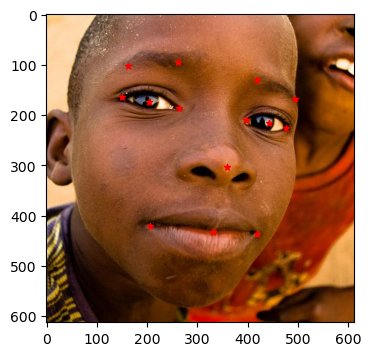

In [7]:
plt.figure(figsize=(4, 4))
show_keypoints(mpimg.imread(os.path.join('train', image_name)), points)
plt.show()

In [8]:
# Creating a class containing data about our photos
face_dataset = dataset_facial_key(csv_file=train, root_dir='train')
print('Length of dataset: ', len(face_dataset)) # Размер датасета

Length of dataset:  5000


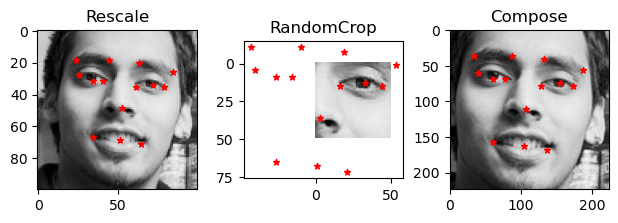

In [9]:
# Testing transformations on a random image

rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

test_num = 144
tem_r = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_r = tx(tem_r)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_r['image'], transformed_r['keypoints'])

plt.show()

In [10]:
# Initializing the model and transferring it to the GPU (if it's possible)

net = Net()
if torch.cuda.is_available(): net.to(torch.device('cuda:0'))

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12800, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=28, bia

In [11]:
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12800, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=28, bia

In [12]:
# Choose the root-mean-square error as the metric
# Choose Adam as the optimization algorithm, since it is the most efficient

criterion = nn.MSELoss()
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)

In [13]:
# Setting the parameters for the transformation of our data

data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor(), Augment_ON()])
data_transform_s = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])
assert(data_transform is not None)
assert(data_transform_s is not None)

In [14]:
# We divide the data for training, validation and testing in the proportions
# of 70%, 20% and 10%, respectively
train_data_s, val_data_s, test_data_s = np.split(train.sample(frac=1, random_state=1),
                                                 [int(.7*len(train)), int(.9*len(train))])

In [16]:
# Creating a transformed dataset

transformed_rr = dataset_facial_key(csv_file=train_data_s, root_dir='train', transform=data_transform)
print('Number of images: ', len(transformed_rr))

# Iterating through the transformed dataset
for i in range(3):
    temp_rr = transformed_rr[i]
    print(i, temp_rr['image'].size(), temp_rr['keypoints'].size())

Number of images:  3500
0 torch.Size([1, 224, 224]) torch.Size([14, 2])
1 torch.Size([1, 224, 224]) torch.Size([14, 2])
2 torch.Size([1, 224, 224]) torch.Size([14, 2])


In [18]:
# Uploading training data

batch_size = 16 # размер батча
train_loader = DataLoader(transformed_rr, batch_size=batch_size, shuffle=True, num_workers=0)

val_dataset = dataset_facial_key(csv_file=val_data_s, root_dir='train', transform=data_transform_s)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

test_dataset = dataset_facial_key(csv_file=test_data_s, root_dir='train', transform=data_transform_s)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [19]:
def net_sample_output():
    
    # Iterating through the test dataset
    for i, sample in enumerate(test_loader):
        
        # Getting images and real points
        images = sample['image']
        key_pts = sample['keypoints']

        # Converting to FloatTensor format
        images = images.type(torch.FloatTensor)
        
        # the prediction of keypoints locationn
        output_pts = net(images.cuda())
        output_pts = output_pts.view(output_pts.size()[0], 14, -1)
        
        if i == 0: return images, output_pts, key_pts

In [20]:
# Получение изображения реальных и предсказанных точек
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 14, 2])
torch.Size([16, 14, 2])


In [21]:
test_images[:,0].shape

torch.Size([16, 224, 224])

In [22]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    # Show image with predicted keypoints
    with torch.no_grad():
        plt.imshow(image, cmap='gray')
        plt.scatter(predicted_key_pts[:, 0].cpu(), predicted_key_pts[:, 1].cpu(), s=20, marker='*', c='r')
        if gt_pts is not None:
            plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [23]:
# Visualization of an image with keypoints

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # Inversion of image transformation
        image = test_images[i].data
        image = image.numpy()   # Tensor -> Numpy
        image = np.transpose(image, (1, 2, 0))   # Torch -> NumPy

        # Inversion of predicted keypoints
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu()
        
        # Inversion of normalization (return to the previous state)
        predicted_key_pts = (predicted_key_pts + 0.5) * 224
        
        # Put the ground truth points on the image
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            # Doing the inversion of transformation
            ground_truth_pts = (ground_truth_pts + 0.5) * 224
        
        # Displaying all keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()

In [24]:
# Initializing the neural network learning function
def train_net(n_epochs):
    
    net.train()
    min_valid_loss = np.inf
    for epoch in range(n_epochs):
        
        # Losses on validation and training samples
        valid_loss = 0.0
        running_loss = 0.0
        for batch_i, data in enumerate(train_loader):
            
            images = data['image']
            key_pts = data['keypoints']
            
            if torch.cuda.is_available():
                images = images.cuda()
                key_pts = key_pts.cuda()
            
            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images.cuda())
            
            loss = criterion(output_pts.cuda(), key_pts.cuda()) # Counting losses

            optimizer.zero_grad()
            
            loss.backward()  # Backward for counting gradients
            optimizer.step() # Updating the weights

            running_loss += loss.item()
                
        train_loss_value = running_loss/len(train_loader) 
        
        # Disabling the accumulation of gradients on the validation sample
        with torch.no_grad():
            
            net.eval()
            for _, data in enumerate(val_loader):

                images = data['image']
                key_pts = data['keypoints']

                if torch.cuda.is_available():
                    images = images.cuda()
                    key_pts = key_pts.cuda()

                key_pts = key_pts.view(key_pts.size(0), -1)
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)

                output_pts = net(images.cuda())
                loss = criterion(output_pts.cuda(), key_pts.cuda())      
                valid_loss += loss.item()
    
                
        print(f'Epoch {epoch+1} \t\t Training Loss: {running_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    
        if min_valid_loss > valid_loss:
            
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            torch.save(net.state_dict(), 'new_model.pt')

    print('Finished Training')

In [23]:
# Training model

n_epochs = 100
train_net(n_epochs)

Epoch 1 		 Training Loss: 0.13904666448156583 		 Validation Loss: 0.028997841690267836
Validation Loss Decreased(inf--->1.826864) 	 Saving The Model
Epoch 2 		 Training Loss: 0.011839295781034653 		 Validation Loss: 0.007574318460972299
Validation Loss Decreased(1.826864--->0.477182) 	 Saving The Model
Epoch 3 		 Training Loss: 0.00595466122371421 		 Validation Loss: 0.003962114013524519
Validation Loss Decreased(0.477182--->0.249613) 	 Saving The Model
Epoch 4 		 Training Loss: 0.0047193634069682055 		 Validation Loss: 0.0031190256270328684
Validation Loss Decreased(0.249613--->0.196499) 	 Saving The Model
Epoch 5 		 Training Loss: 0.003759795080627991 		 Validation Loss: 0.0026685618148702714
Validation Loss Decreased(0.196499--->0.168119) 	 Saving The Model
Epoch 6 		 Training Loss: 0.003496605474990899 		 Validation Loss: 0.0027261675826998222
Epoch 7 		 Training Loss: 0.003059831315270927 		 Validation Loss: 0.002054904162558535
Validation Loss Decreased(0.168119--->0.129459) 	 Sa

Epoch 80 		 Training Loss: 0.0011791962613011435 		 Validation Loss: 0.0009786270832317688
Validation Loss Decreased(0.062163--->0.061654) 	 Saving The Model
Epoch 81 		 Training Loss: 0.001030816869612477 		 Validation Loss: 0.0012138169517533646
Epoch 82 		 Training Loss: 0.0010784913418436057 		 Validation Loss: 0.0009217751175460834
Validation Loss Decreased(0.061654--->0.058072) 	 Saving The Model
Epoch 83 		 Training Loss: 0.0011215841442295542 		 Validation Loss: 0.0011068759541515085
Epoch 84 		 Training Loss: 0.0012293016909064563 		 Validation Loss: 0.0012063348521700217
Epoch 85 		 Training Loss: 0.0013190361561644908 		 Validation Loss: 0.0010341589906371184
Epoch 86 		 Training Loss: 0.0010352623571862878 		 Validation Loss: 0.0011057689553126693
Epoch 87 		 Training Loss: 0.0012191945823020042 		 Validation Loss: 0.0011529377458380564
Epoch 88 		 Training Loss: 0.0011514023203640904 		 Validation Loss: 0.0014654210849945981
Epoch 89 		 Training Loss: 0.0009873280892803515

In [25]:
# Loading the saved model and transferring it to the GPU

net = Net()
net.load_state_dict(torch.load('new_model.pt'))
net.to(torch.device('cuda:0'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=12800, out_features=1024, bias=True)
  (fc1_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=28, bia

In [26]:
# Loading examples of predicted points on test data

test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 14, 2])
torch.Size([16, 14, 2])


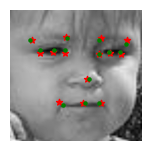

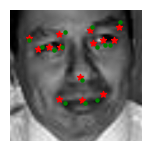

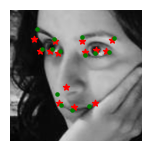

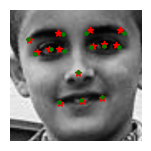

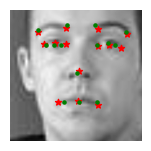

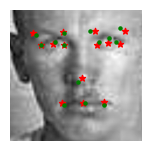

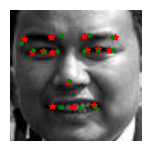

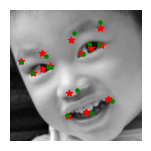

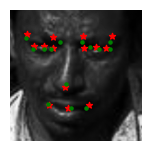

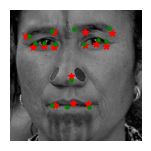

In [27]:
# Visualization of predicted points
visualize_output(test_images, test_outputs, gt_pts)

In [28]:
# Initialize the final file with the coordinates of the points
columns_r=['filename',
           'x1', 'y1', 'x2', 'y2',
           'x3', 'y3', 'x4', 'y4',
           'x5', 'y5', 'x6', 'y6',
           'x7', 'y7', 'x8', 'y8',
           'x9', 'y9', 'x10','y10',
           'x11','y11','x12','y12',
           'x13','y13','x14','y14']

test_final = pd.DataFrame(columns=columns_r)

In [29]:
for filename in os.listdir('test'):
    
    image_gr = mpimg.imread(os.path.join('test', filename))
    h, w = image_gr.shape[:2] # The height and width of the original image
    
    if h > w: new_h, new_w = 250 * h / w, 250 # Making transformations in height and width
    else: new_h, new_w = 250, 250 * w / h

    # Resize
    image_gr_new = cv2.resize(image_gr, (int(new_h), int(new_h)))
    
    # Random cropping of the image to 224*224
    h_r, w_r = image_gr_new.shape[:2]
    new_hr, new_wr = 224, 224

    top = np.random.randint(0, h_r - new_hr)
    left = np.random.randint(0, w_r - new_wr)

    image_gr_new = image_gr_new[top: int(top + new_hr), left: int(left + new_wr)]
    
    # Conversion to black-and-white
    if (image_gr_new.ndim > 2): image_gr_new = cv2.cvtColor(image_gr_new, cv2.COLOR_RGB2GRAY)
    image_gr_new = image_gr_new / 255.0 # Normalization

    im_gr = image_gr_new

    if(len(im_gr.shape) == 2): im_gr = im_gr.reshape(im_gr.shape[0], im_gr.shape[1], 1)
    im_gr = torch.from_numpy(im_gr.transpose((2, 0, 1)))
    im_gr = im_gr.type(torch.FloatTensor)[None, :, :, :]

    out_gr = net(im_gr.cuda()) # Prediction
    out_gr = out_gr.view(out_gr.size()[0], 14, -1)

    # Conversion of the obtained predicted points to the format of the ground truth image
    out_gr = (out_gr + 0.5) * 224
    for i in range (14): 
        out_gr[0][i][0] = out_gr[0][i][0] * h / w
        out_gr[0][i][1] = out_gr[0][i][1] * w / h
    
    for i in range (14):
        out_gr[0][i][0] = (out_gr[0][i][0] + left) * w / 250
        out_gr[0][i][1] = (out_gr[0][i][1] +  top) * h / 250
    
    temp_r = out_gr[0].reshape(-1,28)
    temp_rlist = temp_r[0].tolist()
    
    temp_rlist.insert(0, filename)

    test_final = pd.concat([test_final, pd.DataFrame([temp_rlist], columns=columns_r)],
                           ignore_index=True)

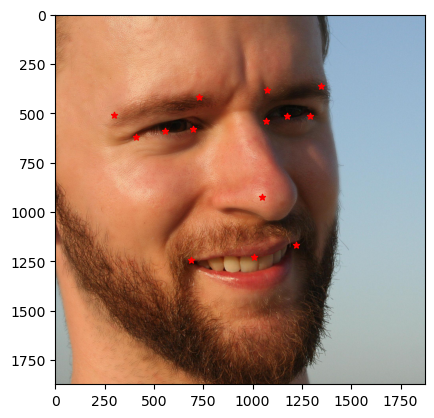

In [212]:
# Example
show_all_keypoints(mpimg.imread('test/00023.jpg'), out_gr[0])

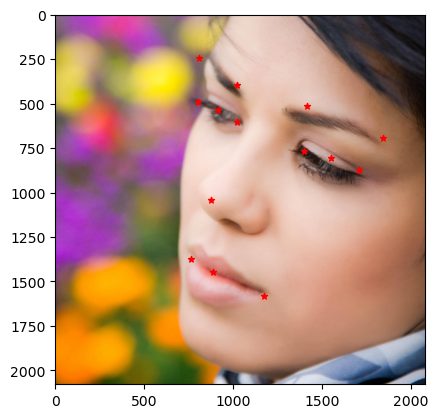

In [274]:
show_keypoints(mpimg.imread('test/01513.jpg'), tout_gr[0])

In [ ]:
# Saving to csv-file

In [30]:
test_final # Prediction for 1000 images that are located in the test folder

,filename,x1,y1,x2,y2,x3,y3,x4,y4,x5,...,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14
0,05892.jpg,8.460436,13.843342,21.194517,10.469559,34.497765,10.962690,44.902363,13.404095,12.082087,...,42.883411,18.582735,30.093950,24.801638,20.538376,38.529037,29.833742,36.991650,36.938087,37.530430
1,00787.jpg,40.986683,51.569389,76.955894,54.121841,116.713600,53.003410,155.240356,48.726570,51.256866,...,147.144974,64.866989,98.292923,112.497505,78.096344,133.781784,101.321968,136.611984,124.661156,133.500565
2,04113.jpg,320.777802,424.690796,649.446533,377.239319,1005.403320,381.895050,1297.961670,415.402893,401.207031,...,1240.175293,571.517822,853.757751,898.858948,621.538025,1227.457275,853.308350,1225.624268,1052.952759,1226.767334
3,05556.jpg,80.641968,80.528526,150.059509,75.125595,225.930634,82.286674,288.159668,96.814552,93.919266,...,273.999359,125.623146,185.208038,188.122330,120.966675,238.365387,181.175003,249.525955,238.801178,244.703781
4,05684.jpg,29.859604,59.318195,65.696541,52.522636,111.907974,44.770668,155.388947,38.314514,43.393040,...,149.771530,58.030209,97.043274,110.025139,80.949936,139.861618,109.522301,138.787445,140.676178,128.796478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,00065.jpg,136.414139,185.865433,275.289093,154.136703,432.107361,149.564087,580.207886,169.324936,169.852875,...,552.921021,237.741776,352.574585,352.268036,254.939362,510.813629,360.047607,503.861969,468.990082,511.379486
996,01370.jpg,51.831661,18.749063,81.546791,33.694836,114.701324,46.155270,148.523911,56.031078,54.747234,...,136.250183,66.762283,78.148697,89.889351,52.897987,100.188087,71.177620,111.346642,95.236557,116.968605
997,05565.jpg,54.221191,50.900215,96.990334,54.455845,152.837585,56.705971,202.981262,58.638939,64.993446,...,192.929031,79.770134,119.331589,131.506195,87.518425,153.521805,123.816490,162.255646,164.127701,155.029831
998,05830.jpg,7.776133,9.734841,15.555350,9.088725,24.357950,9.044779,32.187653,9.469888,9.877143,...,30.795815,12.997221,20.213375,21.433506,13.890169,27.053335,20.485432,27.799156,26.807373,26.471722


In [32]:
test_final.to_csv('test_final.csv', index=False) # Saving